In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

print('OpenCV Version: ', cv2.__version__)

OpenCV Version:  4.1.1


In [3]:
im_file = 'test-images/amitie_witch.png'
im_clean = Image.open(im_file)
im_clean = im_clean.resize((im_clean.width // 2, im_clean.height // 2))
im_clean = np.array(im_clean, dtype=np.uint8)[:, :, :3]

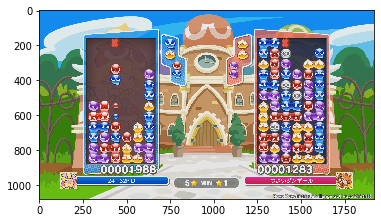

In [4]:
im = Image.open(im_file)
plt.imshow(im, cmap='gray')
plt.show()

Image Dimensions:  (540, 960)


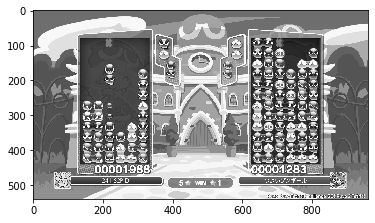

In [5]:
im = im.resize((im.width // 2, im.height // 2))
im = im.convert('L')
im = np.array(im, dtype=np.uint8)
print('Image Dimensions: ', im.shape)
plt.imshow(im, cmap='gray')
plt.show()

## Thresholding Approach (probably not so good)

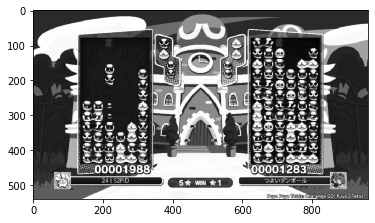

In [6]:
# Use a lookup table to apply contrast stretching to dark regions
xp = [0, 64, 128, 192, 255]
fp = [0, 32, 64, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
new_im = table[im]
new_im = cv2.GaussianBlur(new_im, (5, 5), 0)
plt.imshow(new_im, cmap='gray')
plt.show()

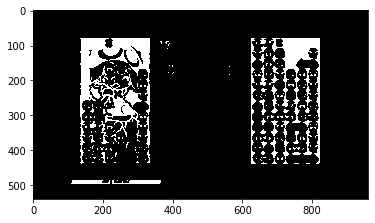

In [7]:
# Get a mask for the dark regions
mask = np.zeros_like(new_im)
mask[new_im < 40] = 255
plt.imshow(mask, cmap='gray')
plt.show()

In [8]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

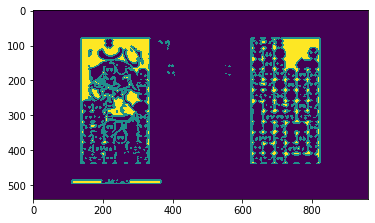

In [9]:
mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, contours, -1, 128, 3)
plt.imshow(mask_copy, cmap='viridis')

In [10]:
# Get bounding boxes for each contour
rects = np.array([cv2.boundingRect(contour) for contour in contours])
areas = rects[:, 2] * rects[:, 3]
print(areas)
# I should actually be using cv2.contourArea

[   12     6  1430  1120    42    20    52    68    48   104   150   180
     4    20     4    15     8     9     8     1   136     6     8     1
    20     2     8    40    25    40    21     6     2     1   114     9
     8    12   544   243     9   285    20     9    20     8    15    24
    40    56     9    56     1    20    70    18   171     1    20     8
     6    25   110    24   154     1     4     1    16   264   396     9
  1100    20     4    20    15    64    45    45    45    18    60     8
   136   110   442   798    12    54   330    48    48   136    35     6
     6   221    12   396  2700  1275  3224    70     3    20     6    25
    30     9    64    56    48    48    20   119     6     8    99    99
    24  1491     6     6   221    16     9   230    20     8    20    15
     7    28    21    18     1   504   378     8   136    18    12     9
   350    20     9  2160     9    60    20     8    48    48     9     1
    20     1     4     8     6     6   725     1  2

In [11]:
# Get indices of the largest contours
inds = np.argsort(-areas)[:5]
print(inds)
big_contours = [contours[ind] for ind in inds]

[243 242 239 241 102]


In [12]:
# big_rects = np.array([cv2.boundingRect(contour) for contour in big_contours])

# rect_contours = []
# for rect in big_rects:
#     x0, y0 = rect[0], rect[1]
#     x1, y1 = x0 + rect[2], y0 + rect[3]
#     cont = [[[x0, y0]],
#             [[x0, y1]],
#             [[x1, y1]],
#             [[x1, y0]]]
#     cont = np.array(cont)
#     rect_contours.append(cont)

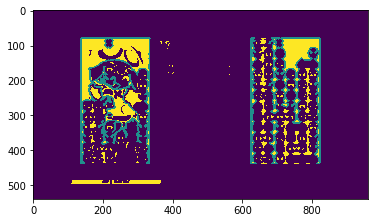

In [13]:
mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, big_contours, -1, 128, 3)
plt.imshow(mask_copy, cmap='viridis')

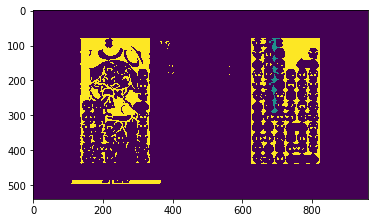

In [14]:
# Next step: Find filled contours, and use those to get the edges?
# And then find the slopes between the edges.
# The 2 objects with similar slopes are the game fields
mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, big_contours, 2, 128, -1)
plt.imshow(mask_copy, cmap='viridis')

## RETR_CCOMP Research

RETR_CCOMP uses a 2-tier hierarchy structure. The first tier contains the contours bounded around True-regions; the second tier contains any "holes", which are basically also the contours bounded around False-regions.

If the game field was thresholded properly, it should be separate from the field border. Therefore, the game field should be in tier-1, and the border should be in tier-2.

See https://docs.opencv.org/3.4/d9/d8b/tutorial_py_contours_hierarchy.html for more details

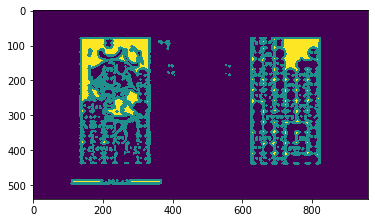

In [15]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, contours, -1, 128, 5)
plt.imshow(mask_copy, cmap='viridis')

In [16]:
# Keep the contours that are tier 1. Tier 1 contours have no parents,
# so the 4th number in the tuple will be -1
hierarchy = hierarchy.reshape(-1, 4)
top_inds = np.argwhere(hierarchy[:, 3] == -1).reshape(-1)
contours = [contours[i] for i in top_inds]
hierarchy = hierarchy[top_inds]

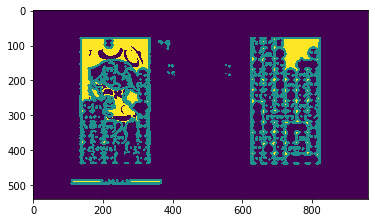

In [17]:
mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, contours, -1, 128, 5)
plt.imshow(mask_copy, cmap='viridis')

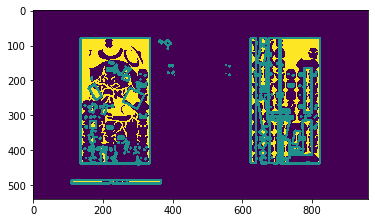

In [18]:
# Find the minimum area, rotated rectangle for each contour
rects = [cv2.minAreaRect(contour) for contour in contours]
rect_points = [cv2.boxPoints(rect).astype(np.int32).reshape((-1, 1, 2)) for rect in rects]
mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, rect_points, -1, 128, 5)
plt.imshow(mask_copy, cmap='viridis')

In [19]:
rects[0]

((269.0, 487.5), (3.0, 2.0), -90.0)

In [20]:
# Find the minimum area, rotated rectangle for each contour
rects = np.array([cv2.boundingRect(contour) for contour in contours])

# Get the areas of the rects
areas = np.array([rect[2] * rect[3] for rect in rects])

# Sort by largest area
inds = np.argsort(-areas)
areas = areas[inds]
rects = rects[inds]

# Get rid of boxes that have less than 3% of the input image's area
inds = np.argwhere(areas > im.shape[0] * im.shape[1] * 0.03).reshape(-1)
areas = areas[inds]
rects = rects[inds]

rect_contour = [np.array([[[x, y]], [[x, y + h]], [[x + w, y + h]], [[x + w, y]]]) for x, y, w, h in rects]

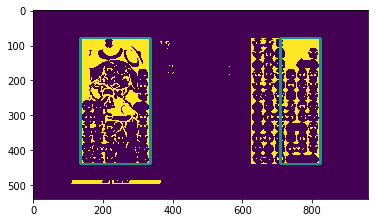

In [21]:
mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, rect_contour, -1, 128, 5)
plt.imshow(mask_copy, cmap='viridis')

In [22]:
# Get data on area, width, height, y pos, and aspect ratio
data = np.array([[area, rect[1], rect[2] / rect[3]] for area, rect in zip(areas, rects)], dtype=np.float)

In [23]:
def pairwise_dist(x, y):
    diff = x[np.newaxis, : , :] - y[:, np.newaxis, :]
    norm = np.linalg.norm(diff, 2, -1)
    dist = norm.transpose()
    np.fill_diagonal(dist, np.infty)
    return dist

dists = pairwise_dist(data, data)
inds = np.array(np.unravel_index(np.argmin(dists), dists.shape))
print(inds, dists[inds])

[0 1] [[           inf 30960.00000092]
 [30960.00000092            inf]]


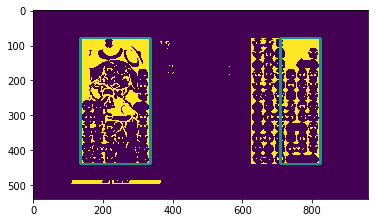

In [24]:
rects = rects[inds]
rect_contour = [np.array([[[x, y]], [[x, y + h]], [[x + w, y + h]], [[x + w, y]]]) for x, y, w, h in rects]

mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, rect_contour, -1, 128, 5)
plt.imshow(mask_copy, cmap='viridis')

Welp. It looks like my results using thresholding + contour finding are dependent on how well the thresholding is done. I need something more intelligent.

## Canny edge detection + Hough Lines

Instead of thresholding, maybe I can use an edge detector

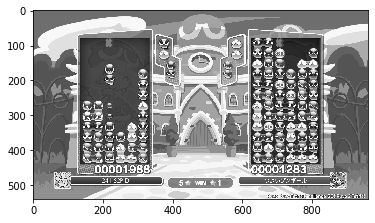

In [25]:
plt.imshow(im, cmap='gray')
plt.show()

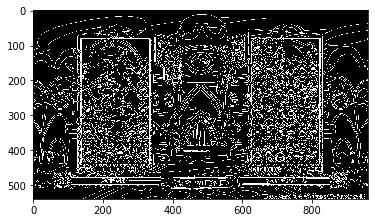

In [138]:
edges = cv2.Canny(im, 0, 30)
plt.imshow(edges, cmap='gray')

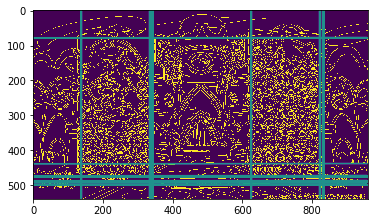

In [144]:
lines = cv2.HoughLines(edges, 1, np.pi / 18, 300, None, 0, 0)
edge_copy = np.copy(edges)
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(edge_copy, pt1, pt2, (128, 0, 0), 3, cv2.LINE_AA)

plt.imshow(edge_copy)

In [154]:
lines.shape

(20, 1, 2)

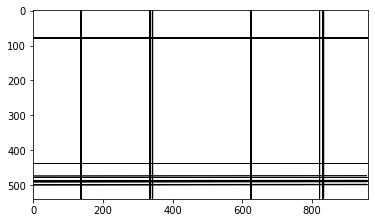

In [69]:
outline_mask = np.zeros(im.shape, dtype=np.uint8)
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(outline_mask, pt1, pt2, 255, 2, cv2.LINE_AA)

outline_mask = 255 - outline_mask
plt.imshow(outline_mask, cmap='gray')

In [70]:
# Get lines as points
line_points = []
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        line_points.append([pt1, pt2])
line_points = np.array(line_points)

# Line intersections
def get_intersect(a1, a2, b1, b2):
    """ 
    https://stackoverflow.com/questions/3252194/numpy-and-line-intersections
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [71]:
import itertools
test = get_intersect(line_points[0, 0], line_points[0, 1], line_points[1, 0], line_points[1, 1])
line_pairs = [comb for comb in itertools.combinations(line_points, 2)]
intersections = []
for line0, line1 in line_pairs:
    intersect = get_intersect(line0[0], line0[1], line1[0], line1[1])
    if intersect[0] != np.inf and intersect[1] != np.inf:
        intersections.append(intersect)
intersections = np.array(intersections)

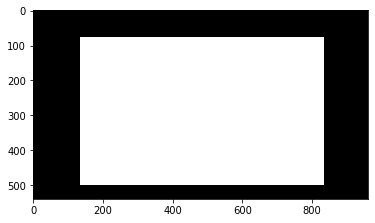

In [72]:
# Get box around intersections
x0, y0 = np.amin(intersections, axis=0)
x1, y1 = np.amax(intersections, axis=0)
x0, y0, x1, y1 = np.int0((x0, y0, x1, y1))

intersect_mask = np.zeros_like(edges)
intersect_mask[y0:y1, x0:x1] = 255
plt.imshow(intersect_mask, cmap='gray')
plt.show()

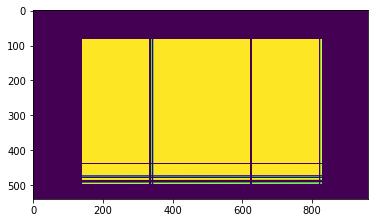

In [81]:
# intersect_mask AND outline_mask
middle_mask = (intersect_mask / 255) * (outline_mask / 255) * 255
middle_mask = middle_mask.astype(np.uint8)
plt.imshow(middle_mask)
plt.show()

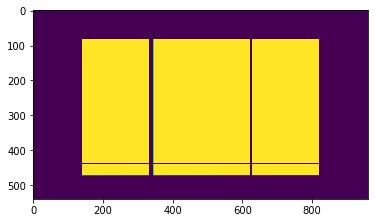

In [94]:
# Binary opening to remove thin lines?
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
opening = cv2.morphologyEx(middle_mask, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)
plt.show()

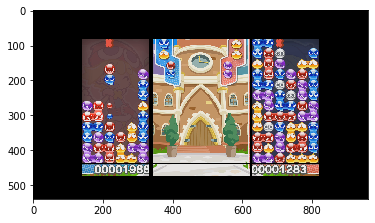

In [98]:
# Check how we're doing
mask_im = np.copy(im_clean)
mask_im[opening == 0] = np.array([0, 0, 0])
plt.imshow(mask_im)

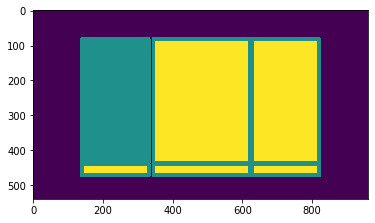

In [148]:
contours, hierarchy = cv2.findContours(opening, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
mask_copy = np.copy(opening)
cv2.drawContours(mask_copy, contours, -1, 128, 10)
cv2.drawContours(mask_copy, contours, 5, 128, -1)
plt.imshow(mask_copy, cmap='viridis')

In [120]:
rects = np.array([cv2.boundingRect(contour) for contour in contours], dtype=np.int)

widths = rects[:, 2]
heights = rects[:, 3] + 1e-8 # Avoid divide by 0 errors
aspect_ratios = widths / heights
print(aspect_ratios)

# Expected aspect ratio
field_ar = (64 * 6) / (60 * 12)

# Calculate percent difference to expected aspect ratio
field_ar_pdiff = (aspect_ratios - field_ar) / ((aspect_ratios + field_ar) / 2)

# Get the rects for contours that have <5% difference
game_fields = rects[field_ar_pdiff < 0.05]
print(game_fields)

[5.81818182 8.42424242 5.81818182 0.53932584 0.78089888 0.53932584]
[[628  82 192 356]
 [140  82 192 356]]


In [155]:
a = np.array([1, 2, 3, 4])
a[a==0]

array([], dtype=int32)

In [139]:
# Get only the 2 that have the smallest distance between their
# y-pos, width, and height
def pairwise_dist(x, y):
    diff = x[np.newaxis, : , :] - y[:, np.newaxis, :]
    norm = np.linalg.norm(diff, 2, -1)
    dist = norm.transpose()
    np.fill_diagonal(dist, np.infty)
    return dist

dists = pairwise_dist(game_fields[:, 1:4], game_fields[:, 1:4])
paired_inds = np.array(np.unravel_index(np.argmin(dists), dists.shape))

game_field_rois = game_fields[paired_inds]

# Sort it so Player 1 (lowest X value) is first
game_field_rois = game_field_rois[np.argsort(game_field_rois[:, 0]), :]

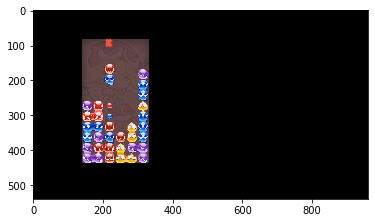

In [152]:
p1_mask = np.zeros_like(im_clean)
x0, x1 = game_field_rois[0, 0], game_field_rois[0, 0] + game_field_rois[0, 2]
y0, y1 = game_field_rois[0, 1], game_field_rois[0, 1] + game_field_rois[0, 3]
p1_mask[y0:y1, x0:x1] = 255
p1_field = cv2.bitwise_and(im_clean, p1_mask)
plt.imshow(p1_field)